# Universal noise

This notebook computes a universal noise pattern, which can be added to any image 
and missleads the open pose network 

In [1]:
%load_ext autoreload
%autoreload 2
# imports
import datetime
import logging
import os
import pathlib
import sys

import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns


from loss_functions import multi_stage_loss
from plot_utils import gen_plot_universal_noise, plot_pose
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator,PoseEstimator
from tf_pose.networks import get_graph_path
from utils import load_batch, pose_loss_single_human, compare_poses
from PIL import Image
import glob 
import wandb
import random

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
logging.getLogger("wandb").setLevel(logging.ERROR)
random.seed(42)

Using tf version = 1.13.1


In [2]:
def get_image_transform_mask(directory):
    image_path_targets = []
    image_targets = []
    image_masks = []
    image_transforms = []
    for file in glob.glob(f"{directory}/*.xml"):
        filename, file_extension = os.path.splitext(file)
        
        image_path_targets.append(filename)
        
        image_targets.append(common.read_imgfile(f'{filename}.jpg', IMAGE_WIDTH, IMAGE_HEIGHT))
        
        mask = common.read_imgfile(f'{filename}_mask.png', IMAGE_WIDTH, IMAGE_HEIGHT, cv2.IMREAD_GRAYSCALE) > 0
        image_masks.append(np.array(np.repeat(mask[:, :, np.newaxis], 3, 2)))
        
        image_transforms.append(np.load(f'{filename}_warp.npy') )
    
    merged_list = list(zip(image_path_targets, image_targets, image_masks, image_transforms))
    
    random.shuffle(merged_list)
    image_path_targets, image_targets, image_masks, image_transforms = zip(*merged_list)
    
    return image_path_targets, image_targets, image_masks, image_transforms

In [11]:
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
NOISE_WIDTH, NOISE_HEIGHT = 200, 400
RESIZE_OUT_RATIO = 2.0
SNAPSHOT_NAME = f'../snapshots/universal_noise_with_warp_PAF.npy'

train_dir = '../data/generated/train'
test_dir = '../data/generated/test'
[train_image_path_targets, 
 train_image_targets, 
 train_image_masks, 
 train_image_transforms] = get_image_transform_mask(train_dir)

[test_image_path_targets, 
 test_image_targets, 
 test_image_masks, 
 test_image_transforms] = get_image_transform_mask(test_dir)
print(f'Found {len(train_image_path_targets)} train images')
print(f'Found {len(test_image_path_targets)} test images')

Found 1800 train images
Found 200 test images


In [4]:
# the input image
sample_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='sample'
)

# the current universal noise
universal_noise_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='universal_noise'
)

# create a placeholder for the transform
transforms_tensor = tf.placeholder(
    tf.float32,
    shape=(None, 8),
    name='2d_transform'
)

mask_tensor = tf.placeholder(
    tf.bool,
    shape=(None, None, None, 3),
    name='mask'
)

# warp the noise 
warped_universal_noise_tensor = tf.contrib.image.transform(
    universal_noise_tensor,
    transforms_tensor,
    interpolation='NEAREST',
    output_shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
    name='warped_universal_noise'
)


ax_input_overwrite_tensor = tf.where(
    mask_tensor,
    warped_universal_noise_tensor,
    sample_tensor,
    name='ax_input_overwrite'
)

In [5]:
estimator = TfPoseEstimator(
    get_graph_path('cmu'), 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    trt_bool=False, input_overwrite_tensor=ax_input_overwrite_tensor, sample_image=sample_tensor)

In [6]:
image_target = train_image_targets[0]

UPSAMPLE_SIZE = np.array([int(estimator.target_size[1] / 8 * RESIZE_OUT_RATIO),
                 int(estimator.target_size[0] / 8 * RESIZE_OUT_RATIO)])
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = estimator.persistent_sess.run(
    [
        estimator.tensor_output, 
        estimator.tensor_heatMat_up,
        estimator.tensor_pafMat_up,
        estimator.tensor_peaks
    ],
    feed_dict={
        # the current sample image 
        sample_tensor: [image_target],
        # the current universal noise
        universal_noise_tensor: [np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3))],
        # the current 2d warp
        transforms_tensor: [[1, 0, 0, 0, 1, 0, 0, 0]],
        # the upsample size
        estimator.upsample_size: UPSAMPLE_SIZE, 
        mask_tensor: [np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3))]
    }
)

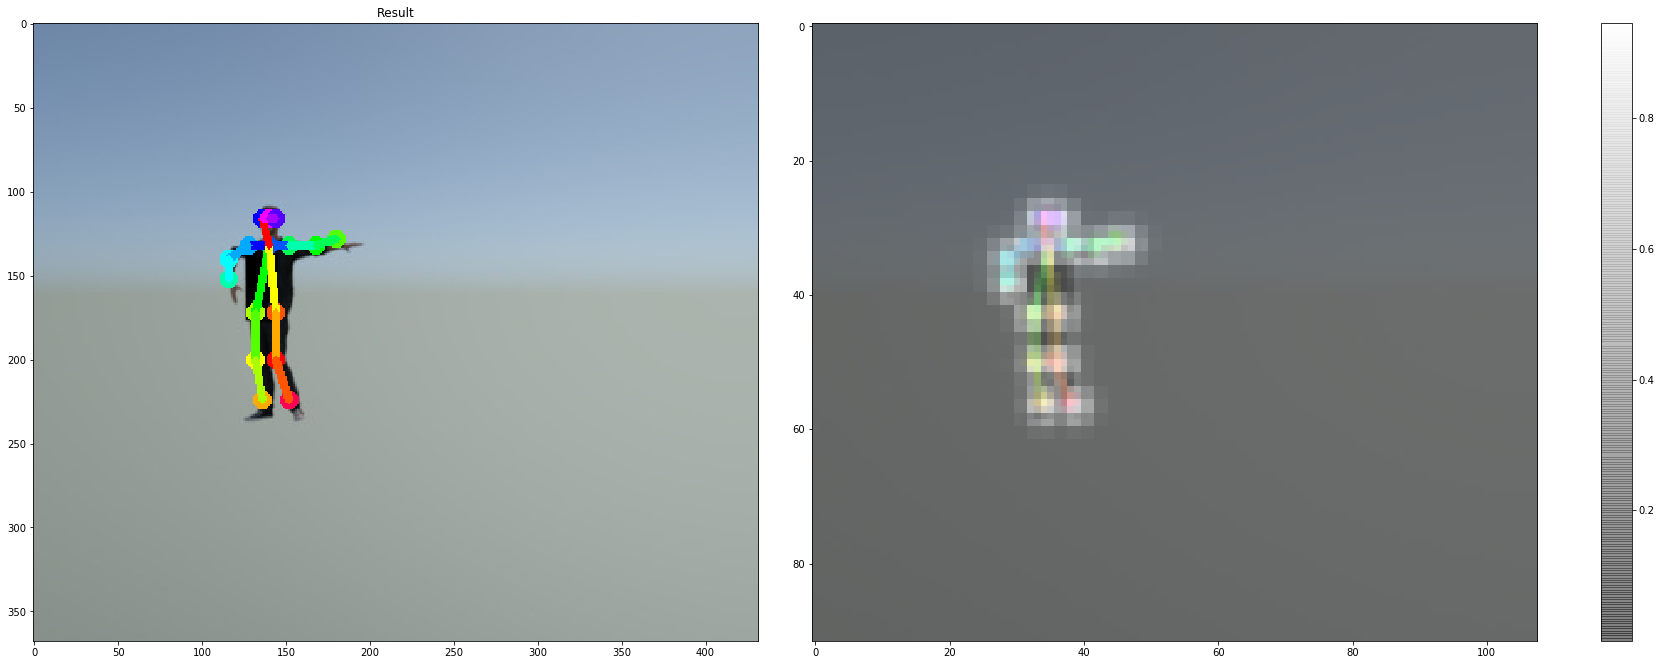

In [7]:
human_target = estimator.inference(
    image_target, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
plot_pose(image_target, human_target, estimator.heatMat)

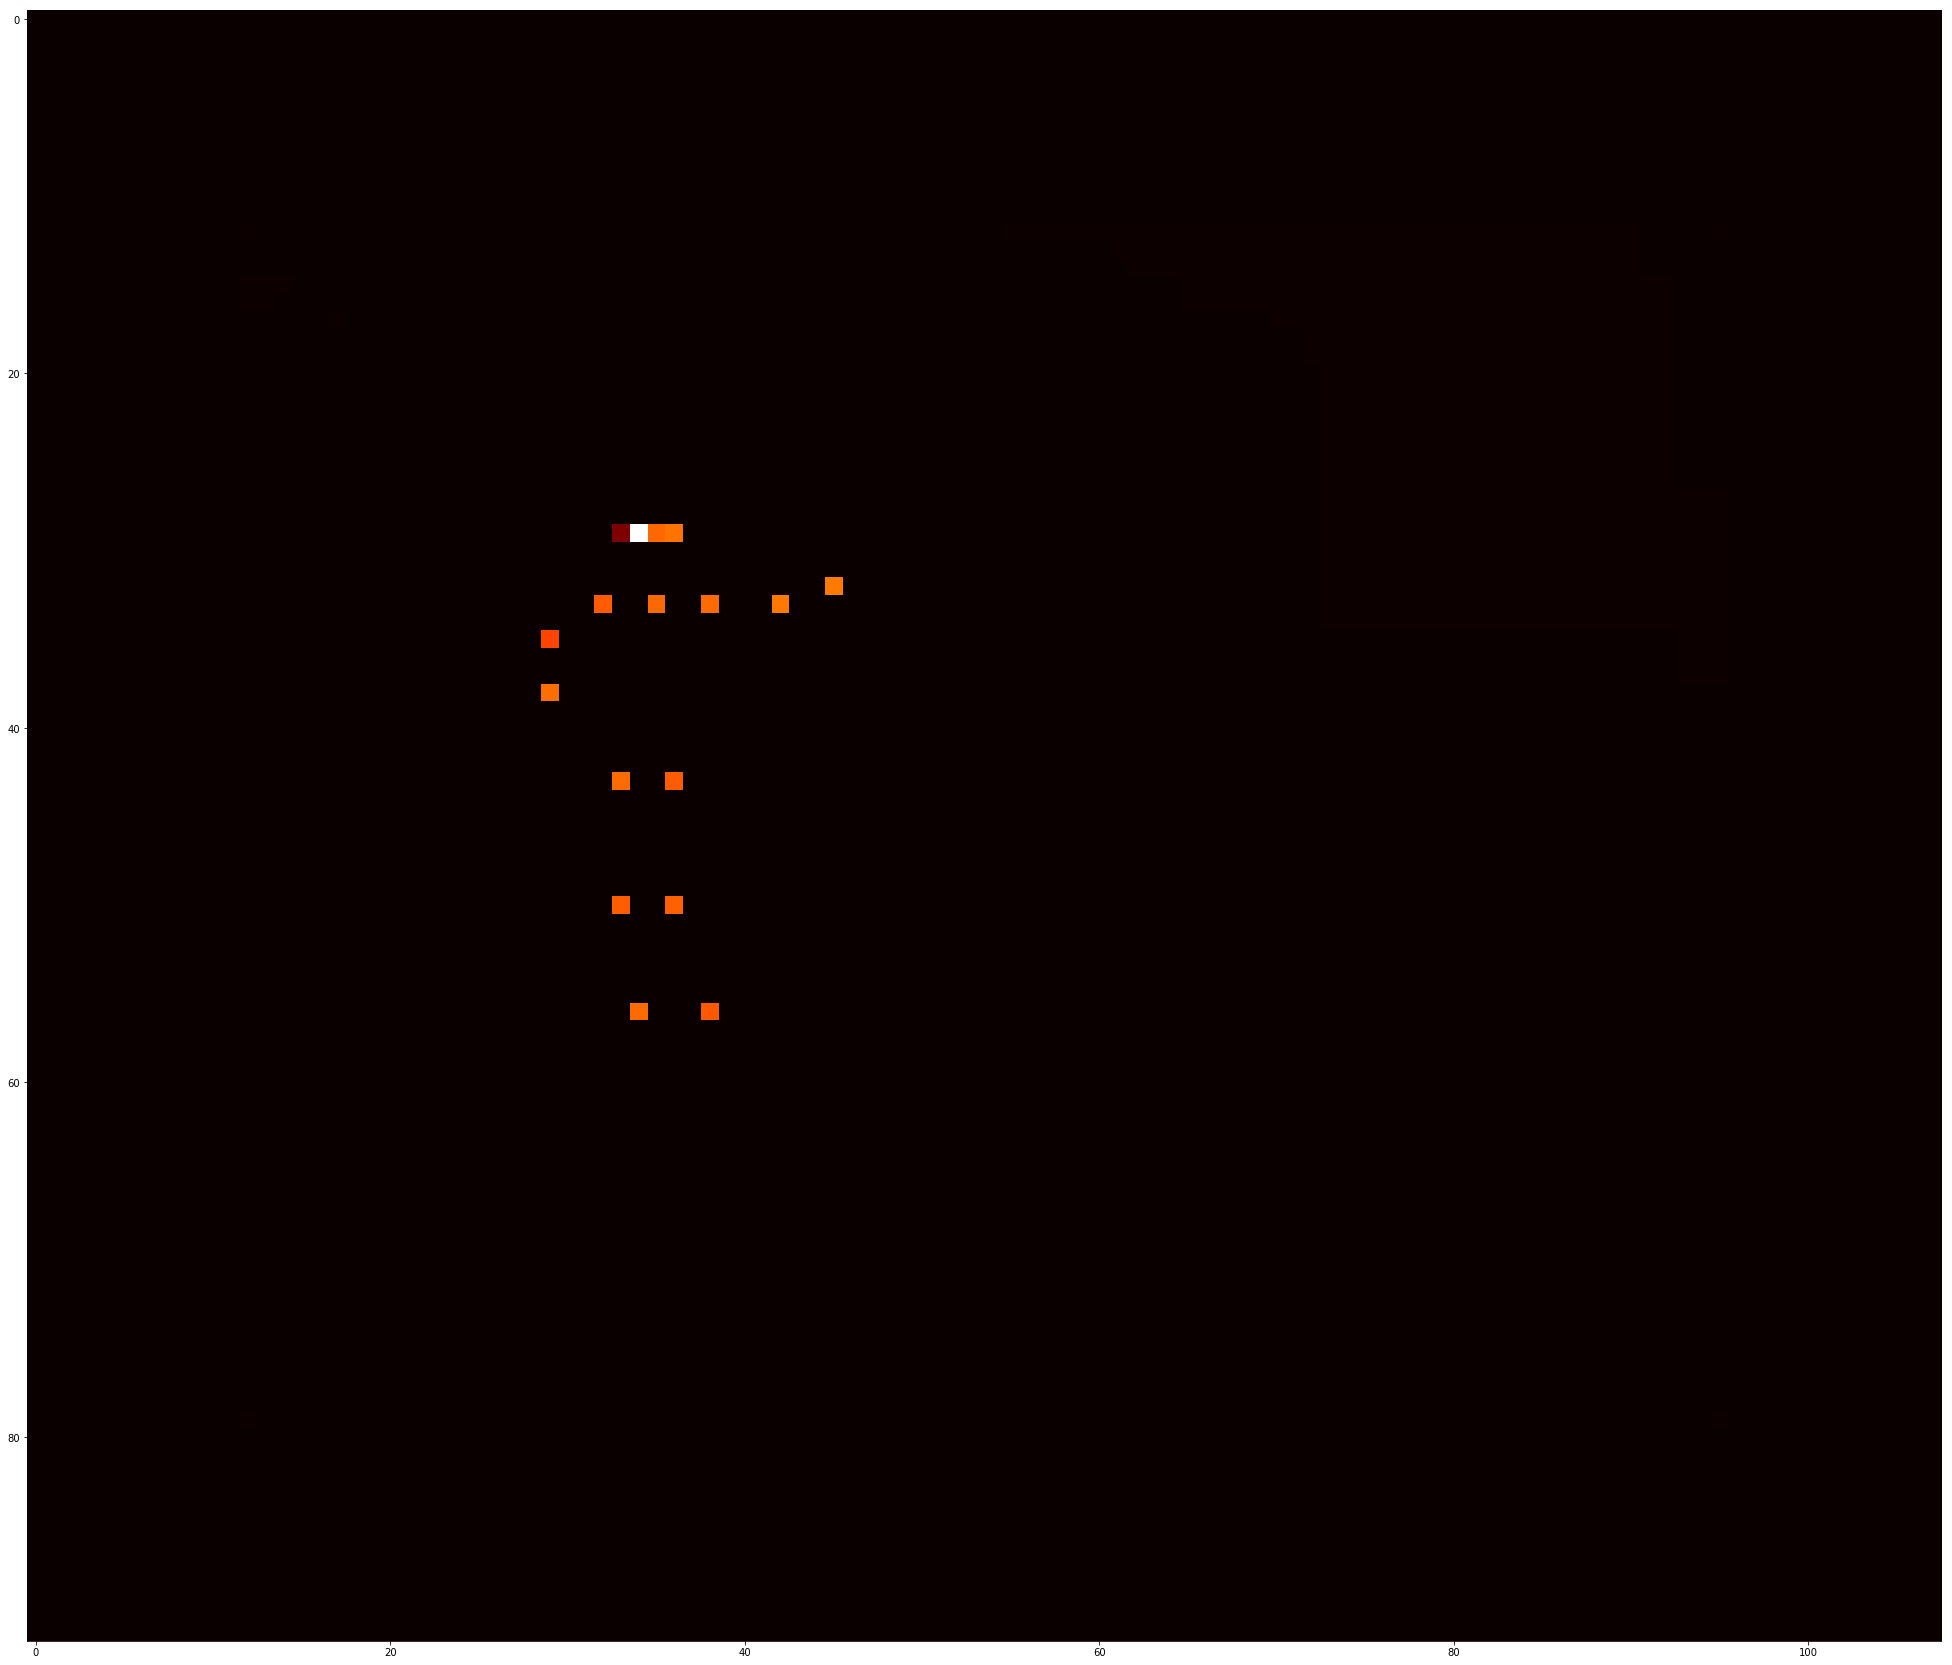

In [8]:
peaks = np.sum(estimator.peaks[:, :, :18], axis=2)
fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(1,1, 1)
ax.imshow(peaks, cmap=plt.cm.hot)

In [9]:
def wandb_init(name):
    run = wandb.init(
        project = "2d_warp_universal_noise", 
        reinit = True,
        name = name,
        config={
            "epochs": 5,
            "epsilon": 5000,
            "upsample_size_0": UPSAMPLE_SIZE[0],
            "upsample_size_1": UPSAMPLE_SIZE[1],
            "batch_size": 16,
            "image_width": IMAGE_WIDTH,
            "image_height": IMAGE_HEIGHT,
            "noise_width": NOISE_WIDTH,
            "noise_height": NOISE_HEIGHT,
        }
    )
    
    return run 

def multi_stage_loss_with_2D_warp(estimator, target_heat, target_paf, universal_noise_tensor):
    losses_per_stage = []
    stage = 6
    # compute loss per stage
    
    paf_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
    heat_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

    # compute the loss for every channel
    loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))

    # combined loss form every stage
    total_loss = tf.reduce_sum([loss_paf, loss_heat])

    grad = tf.gradients(total_loss, universal_noise_tensor)[0]
    # compute the average
    grad = tf.reduce_mean(grad, 0)
    return grad, total_loss,

def multi_stage_loss_with_2D_warp_paf(estimator, universal_noise_tensor):
    losses_per_stage = []
    stage = 6
    
    # compute loss per stage
    paf_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
    loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
    
    # combined loss form every stage
    total_loss = tf.reduce_sum([loss_paf])

    grad = tf.gradients(total_loss, universal_noise_tensor)[0]
    # compute the average
    grad = tf.reduce_mean(grad, 0)
    return grad, total_loss,

def load_batch_with_transform(image_targets, image_masks, image_transforms, start_index, batch_size):
    i = start_index
    batch_image = []
    batch_mask = []
    batch_transform = []
    while len(batch_image) < batch_size:
        if i >= len(image_targets):
            i = 0
        batch_image.append(image_targets[i])
        batch_mask.append(image_masks[i])
        batch_transform.append(image_transforms[i])
        i += 1
    return np.asarray(batch_image), np.asarray(batch_mask), np.asarray(batch_transform), i

def get_universal_noise(estimator, image_targets, masks, transforms):
    cur_run = wandb_init(f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}_run')
    with cur_run:
        upsample_size = [cur_run.config.upsample_size_0, cur_run.config.upsample_size_0]

        # get all outputs as np matrix
        target_np_heat = np.zeros((cur_run.config.batch_size, 46, 54, 19))
        target_np_paf = np.zeros((cur_run.config.batch_size, 46, 54, 38))

        # where does the current batch start
        training_stats = {
            'gobal_step': 0,
            'batch_index': 0,
            'universal_noise': np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3)),
            'file_name': SNAPSHOT_NAME
        }

        target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
        target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
        #         grad_func, loss_func = multi_stage_loss_with_2D_warp(
#             estimator, 
#             target_heat, 
#             target_paf, 
#             universal_noise_tensor)
        
        grad_func, loss_func = multi_stage_loss_with_2D_warp_paf(
            estimator, 
            universal_noise_tensor)
        
        steps = len(image_targets) // cur_run.config.batch_size
        

        ### ================= TRAINING ================= ###
        for epoch in range(cur_run.config.epochs):
            print(f"run {epoch + 1}/{cur_run.config.epochs}")
            for step in tqdm(range(steps)):
                (batch_image, 
                 batch_mask, 
                 batch_transform, 
                 training_stats['batch_index']
                ) = load_batch_with_transform(
                    train_image_targets, 
                    train_image_masks,
                    train_image_transforms,
                    training_stats['batch_index'], 
                    cur_run.config.batch_size
                )
                
                repeated_noise = np.repeat(np.expand_dims(
                    training_stats['universal_noise'], axis=0), cur_run.config.batch_size, 0)


                feed_dict = {
                    # the target heatmap
                    target_heat: target_np_heat,
                    # the target paf
                    target_paf: target_np_paf,
                    # the current sample images
                    sample_tensor: batch_image,
                    # the current universal noise
                    universal_noise_tensor: repeated_noise,
                    # the current 2d warp
                    transforms_tensor: batch_transform,
                    # the upsample size
                    estimator.upsample_size: upsample_size,
                    mask_tensor: batch_mask
                }


                gradient, loss = estimator.persistent_sess.run(
                    [grad_func, loss_func],
                    feed_dict=feed_dict
                )
                

                wandb.log({'loss': loss}, step=training_stats['gobal_step'])

                if step % 100 == 0:
                    # save universal noise
                    np.save(training_stats['file_name'], training_stats['universal_noise'])
                    wandb.log({
                        'universal_noise': wandb.Image(
                            np.clip(training_stats['universal_noise'], 0, 255), 
                            caption='universal noise'
                        )
                    }, step=training_stats['gobal_step'])

                ### ================= UPDATE STEP ================= ###
                scaled_gradient = (cur_run.config.epsilon * gradient)            

                training_stats['universal_noise'] = training_stats['universal_noise'] - scaled_gradient
                training_stats['universal_noise'] = np.clip(training_stats['universal_noise'], 0, 255)
                training_stats['gobal_step'] += 1


    return training_stats['universal_noise'],scaled_gradient

In [12]:
universal_noise, scaled_gradient = get_universal_noise(
        estimator, 
        train_image_targets, 
        train_image_masks, 
        train_image_transforms
    )


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5



100%|██████████| 112/112 [01:07<00:00,  1.67it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5



100%|██████████| 112/112 [01:05<00:00,  1.72it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5



100%|██████████| 112/112 [01:05<00:00,  1.72it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5



100%|██████████| 112/112 [01:05<00:00,  1.72it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5



100%|██████████| 112/112 [01:05<00:00,  1.72it/s]


(400, 200, 3)
float64


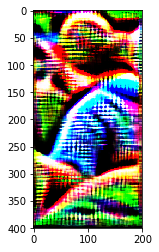

In [13]:
universal_noise = np.load(SNAPSHOT_NAME)
print(universal_noise.shape)
print(universal_noise.dtype)
universal_noise_image = Image.fromarray(universal_noise.astype(np.uint8))
b, g, r = universal_noise_image.split()
universal_noise_image = Image.merge("RGB", (r, g, b))
plt.imshow(universal_noise_image)

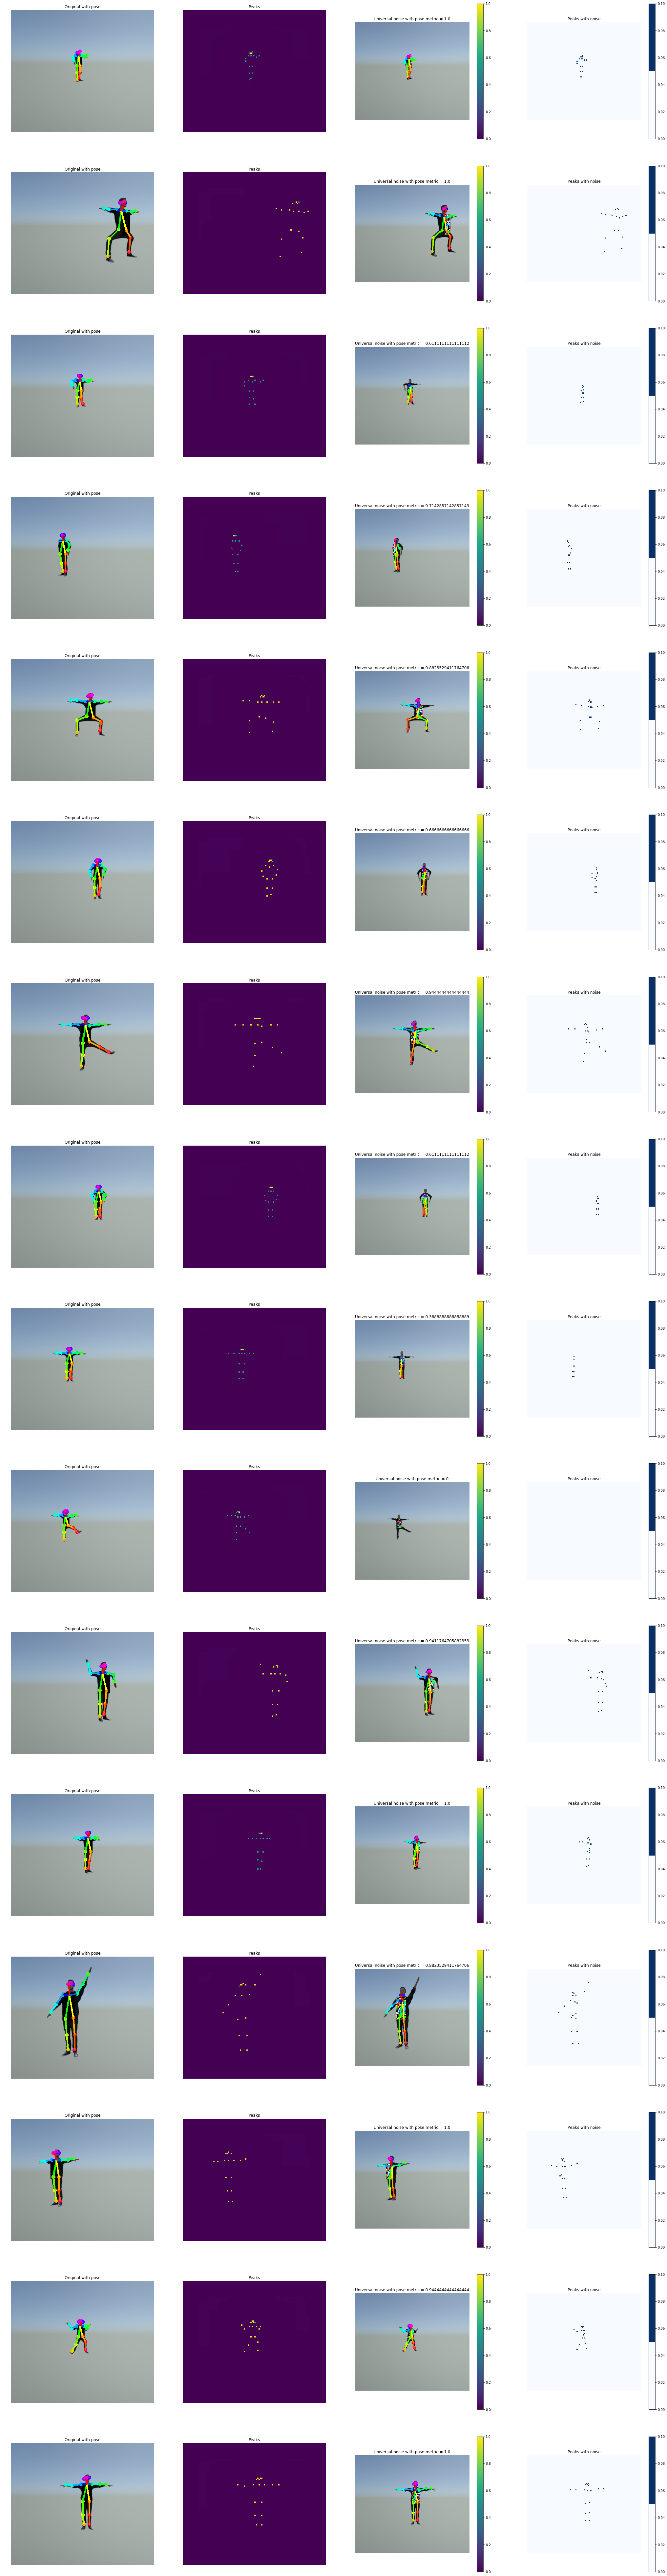

In [14]:
# Plot attributions
%matplotlib inline

test_batch_size = 16
test_batch_start = 0
(test_batch_image, 
 test_batch_mask, 
 test_batch_transform, 
 _
) = load_batch_with_transform(
    test_image_targets, 
    test_image_masks,
    test_image_transforms,
    test_batch_start,
    test_batch_size
)

n_cols = 4
n_rows = len(test_batch_image)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

plot_cnt = 0

universal_noise_image = Image.fromarray(universal_noise.astype(np.uint8))
b, g, r = universal_noise_image.split()
universal_noise_image = Image.merge("RGB", (r, g, b))


for i, xi in enumerate(test_batch_image):
    detections = estimator.inference(xi, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
    detections_result = TfPoseEstimator.draw_humans(xi, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Original with pose')
    ax.axis('off')
    plot_cnt += 1
    
    # compute peaks
    peaks = np.sum(estimator.peaks[:, :, :18], axis=2)
    ax = axes.flatten()[plot_cnt]
    ax.imshow(peaks)
    ax.set_title(f'Peaks')
    ax.axis('off')
    plot_cnt += 1
    
    
    transforms = [test_batch_transform[i]]

    detections_noise = estimator.inference(
        xi, 
        resize_to_default=True, 
        upsample_size=RESIZE_OUT_RATIO, 
        transforms=transforms,
        universal_noise=[universal_noise],
        mask=[test_batch_mask[i]]
    )
    detections_result_noise = estimator.draw_humans_warped(
        [xi], 
        detections_noise, 
        [universal_noise], 
        transforms, 
        [test_batch_mask[i]])
    
    metric = pose_loss_single_human(detections_noise, detections)
    
    ax = axes.flatten()[plot_cnt]
    heat_image = ax.imshow(cv2.cvtColor(np.clip(detections_result_noise, 0, 255), cv2.COLOR_BGR2RGB) / 255.0)
    ax.set_title(f'Universal noise with pose metric = {metric}')
    ax.axis('off')
    fig.colorbar(heat_image, ax=ax, shrink=1.0)
    plot_cnt += 1
    
    # compute peaks
    peaks = np.sum(estimator.peaks[:, :, :18], axis=2)
    ax = axes.flatten()[plot_cnt]
    heat_image = ax.imshow(peaks, cmap=plt.cm.get_cmap('Blues', 2), vmin=0, vmax=0.1)
    ax.set_title(f'Peaks with noise')
    ax.axis('off')
    fig.colorbar(heat_image, ax=ax, shrink=1.0)
    plot_cnt += 1
    

In [15]:
error_values = []
# compute total error metric 
for image, mask, transform in tqdm(zip(test_image_targets, test_image_masks, test_image_transforms), total=len(test_image_targets)):
    detections = estimator.inference(image, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
    
    detections_noise = estimator.inference(
        image, 
        resize_to_default=True, 
        upsample_size=RESIZE_OUT_RATIO, 
        transforms=[transform],
        universal_noise=[universal_noise],
        mask=[mask]
    )
    error_values.append(pose_loss_single_human(detections_noise, detections))


 78%|███████▊  | 155/200 [00:18<00:05,  8.43it/s]


100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


In [16]:
print(np.mean(error_values))

0.7592298085901027


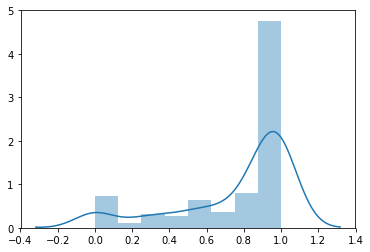

In [17]:
sns.distplot(error_values)

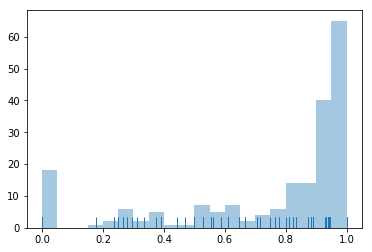

In [18]:
sns.distplot(error_values, bins=20, kde=False, rug=True);